##### 1. TRADITIONAL APPROACHES

We benchmarked the following tools:
> Prodigal, Glimmer, GeneMark

In [1]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = "/home/biolab-office-1/DATALAB/DEV/GeneLM/benchmark/results"
METHODS = [
        ("GeneLM", "our_tool.gff"),
        ("Prodigal v3.0", "prodigal.gff"), 
        ("GeneMark-HMM v2.8", "genemark-hmm.gff"),
        ("Glimmer-schatch v3.02", "glimmer-from-scratch.gff"),
        ("Glimmer-iterated v3.02", "glimmer-iterated.gff"),
        #    ("Glimmer-training-1.3", "glimmer-training-1.3.gff"),
        #    ("Glimmer-training-1.2", "glimmer-training-1.2.gff"),
        #    ("Glimmer-training-2.3", "glimmer-training-2.3.gff"),
        #    ("Glimmer-training-3.3", "glimmer-training-3.3.gff")
]

In [3]:
def parse_gff(file_path):
    cds_positions = set()
    
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("#") or "\tCDS\t" not in line:
                continue
            parts = line.strip().split("\t")
            if "our_tool" in file_path:
                # **** If wonder why +2 *****
                # In early stage of our development We did some processing error while genering the gff with our tool.
                # For the release version of the webtool, this has been fixed. But in this benchmarch we are using the old output of prediction in
                # the verified genomes SO WE JUST FIXED IT HERE ADDING +2 to the start position of the CDS.
                # ***************************
                seqid, start, end, strand = str(parts[0]), int(parts[3])+2, int(parts[4]), parts[6]
            else:
                seqid, start, end, strand = str(parts[0]), int(parts[3]), int(parts[4]), parts[6]
            cds_positions.add((seqid, start, end, strand))
    
    return cds_positions

* View 1

In [4]:
def normalize_3end(cds_set):
    return set((seqid, end, strand) if strand == "+" else (seqid, start, strand) for (seqid, start, end, strand) in cds_set)

def normalize_3_5ends(cds_set):
    return set((seqid, start, end, strand) for (seqid, start, end, strand) in cds_set)

comparison_results = []
GC = [50.8, 65.7, 65.6, 63.1, 58.9]

for i, bacteria_folder in enumerate(sorted(os.listdir(BASE_DIR))):
    bacteria_path = os.path.join(BASE_DIR, bacteria_folder)
    if not os.path.isdir(bacteria_path):
        continue

    verified_file = os.path.join(bacteria_path, "verified.gff")
    verified_cds_raw = parse_gff(verified_file)
    verified_cds = normalize_3end(verified_cds_raw)
    verified_tis = normalize_3_5ends(verified_cds_raw)
    bacteria_data = {"Bacteria": bacteria_folder, "GC": GC[i], "Total Verified CDS": len(verified_cds)}

    for method_name, method in METHODS:
        method_file = os.path.join(bacteria_path, method)
        method_cds_raw = parse_gff(method_file)
        method_cds = normalize_3end(method_cds_raw)
        method_tis = normalize_3_5ends(method_cds_raw)

        matched_cds = method_cds.intersection(verified_cds)
        matched_tis = method_tis.intersection(verified_tis)
        missed_cds = verified_cds - method_cds
        missed_tis = verified_tis - method_tis
        extra_cds = method_cds - verified_cds
        extra_tis = method_tis - verified_tis

        bacteria_data[f"{method_name}_Matched TIS"] = len(matched_tis)
        bacteria_data[f"{method_name}_Missed TIS"] = len(missed_tis)
        bacteria_data[f"{method_name}_Total Found CDS"] = len(method_cds)

    comparison_results.append(bacteria_data)

# AGG
df_tmp = pd.DataFrame(comparison_results)
summary_row = {
    "Bacteria": "All Genomes",
    "GC": "-",
    "Total Verified CDS": df_tmp["Total Verified CDS"].sum()
}

# Aggregate all method-based numeric columns
method_cols = [col for col in df_tmp.columns if col not in ["Bacteria", "GC", "Total Verified CDS"]]
for col in method_cols:
    summary_row[col] = df_tmp[col].sum()

comparison_results.append(summary_row)

In [5]:
df_results = pd.DataFrame(comparison_results)
df = df_results

# Fusion
df_melted = df.melt(id_vars=["Bacteria", "GC", "Total Verified CDS"], var_name="Method_Metric", value_name="Value")
df_melted[['Method', 'Metric']] = df_melted['Method_Metric'].str.rsplit("_", n=1, expand=True)
df_pivot = df_melted.pivot(index=["Bacteria", "GC", "Total Verified CDS"], columns=["Method", "Metric"], values="Value")
df_pivot = df_pivot.reset_index()

# df_pivot = df_pivot.sort_index(axis=1, level=0)
df_pivot = pd.concat([df_pivot.iloc[1:], df_pivot.iloc[[0]]], ignore_index=True)
df_pivot.to_csv('output/traditional/benchmarck-v0-classic.csv')
df_pivot.head(8)

Method                                       Bacteria    GC  \
Metric                                                        
0       Escherichia_coli_K_12_substr__MG1655_uid57779  50.8   
1                 Halobacterium_salinarum_R1_uid61571  65.7   
2           Mycobacterium_tuberculosis_H37Rv_uid57777  65.6   
3            Natronomonas_pharaonis_DSM_2160_uid58435  63.1   
4                    Roseobacter_denitrificans_Och114  58.9   
5                                         All Genomes     -   

Method Total Verified CDS      GeneLM                             \
Metric                    Matched TIS Missed TIS Total Found CDS   
0                     769         744         25            4213   
1                     530         438         92            2659   
2                     701         626         75            3853   
3                     315         248         67            2737   
4                     526         492         34            4006   
5                    2841        2548        293           17468   

Method Prodigal v3.0                            GeneMark-HMM v2.8             \
Metric   Matched TIS Missed TIS Total Found CDS       Matched TIS Missed TIS   
0                338        431            4347               595        174   
1                243        287            2851               493         37   
2                311        390            4204               545        156   
3                169        146            2873               302         13   
4                  0        526            4120                 0        526   
5               1061       1780           18395              1935        906   

Method                 Glimmer-schatch v3.02                             \
Metric Total Found CDS           Matched TIS Missed TIS Total Found CDS   
0                 4308                   276        493            4397   
1                 2762                   220        310            2717   
2                 4029                   274        427            4240   
3                 2826                   164        151            2878   
4                 4104                   204        322            4260   
5                18029                  1138       1703           18492   

Method Glimmer-iterated v3.02                             
Metric            Matched TIS Missed TIS Total Found CDS  
0                         319        450            4478  
1                         220        310            2762  
2                         271        430            4349  
3                         163        152            2894  
4                         233        293            4345  
5                        1206       1635           18828

* View 2

In [6]:
def normalize_3end(cds_set):
    return set((seqid, end, strand) if strand == "+" else (seqid, start, strand) for (seqid, start, end, strand) in cds_set)

def normalize_3_5ends(cds_set):
    return set((seqid, start, end, strand) for (seqid, start, end, strand) in cds_set)


comparison_results = []
GC = [50.8, 65.7, 65.6, 63.1, 58.9]

for i, bacteria_folder in enumerate(sorted(os.listdir(BASE_DIR))):
    bacteria_path = os.path.join(BASE_DIR, bacteria_folder)
    if not os.path.isdir(bacteria_path):
        continue

    verified_file = os.path.join(bacteria_path, "verified.gff")
    verified_cds_raw = parse_gff(verified_file)
    verified_cds = normalize_3end(verified_cds_raw)
    verified_tis = normalize_3_5ends(verified_cds_raw)
    bacteria_data = {"Bacteria": bacteria_folder, "GC": GC[i], "Verified TIS": len(verified_tis)}

    for method_name, method_file in METHODS:
        method_file_path = os.path.join(bacteria_path, method_file)
        method_cds_raw = parse_gff(method_file_path)
        method_cds = normalize_3end(method_cds_raw)
        method_tis = normalize_3_5ends(method_cds_raw)

        matched_cds = method_cds & verified_cds
        matched_tis = method_tis & verified_tis

        bacteria_data[f"{method_name}_(5’+3’) ends"] = (
            f"{len(matched_tis)} ({(100 * len(matched_tis) / len(verified_tis)):.1f}%)"
        )
        bacteria_data[f"{method_name}_3’ end"] = (
            f"{len(matched_cds)} ({(100 * len(matched_cds) / len(verified_cds)):.1f}%)"
        )
        bacteria_data[f"{method_name}_Found CDS"] = (
            f"{len(method_cds)}"
        )

    comparison_results.append(bacteria_data)

# Aggregate summary
import re
def extract_leading_number(s):
    if isinstance(s, str):
        match = re.match(r"(\d+)", s.strip())
        return int(match.group(1)) if match else 0
    return 0

df_tmp = pd.DataFrame(comparison_results)
summary_row = {
    "Bacteria": "All Genomes",
    "GC": "-",
    "Verified TIS": df_tmp["Verified TIS"].sum()
}

metric_cols = [col for col in df_tmp.columns if col not in ["Bacteria", "GC", "Verified TIS"]]
for col in metric_cols:
    total = df_tmp[col].apply(extract_leading_number).sum()
    if "_Found CDS" in col:
        summary_row[col] = f"{total}"
    else:
        percent = (100 * total / summary_row["Verified TIS"]) if summary_row["Verified TIS"] else 0
        summary_row[col] = f"{total} ({percent:.1f}%)"

comparison_results.append(summary_row)

In [ ]:

df_results = pd.DataFrame(comparison_results)
df = df_results

# Fusion
df_melted = df.melt(id_vars=["Bacteria", "GC", "Verified TIS"], var_name="Method_Metric", value_name="Value")
df_melted[['Method', 'Metric']] = df_melted['Method_Metric'].str.rsplit("_", n=1, expand=True)
df_pivot = df_melted.pivot(index=["Bacteria", "GC", "Verified TIS"], columns=["Method", "Metric"], values="Value")
df_pivot = df_pivot.reset_index()

# df_pivot = df_pivot.sort_index(axis=1, level=0)
df_pivot = pd.concat([df_pivot.iloc[1:], df_pivot.iloc[[0]]], ignore_index=True)


df_pivot.head(8)

Method                                       Bacteria    GC Verified TIS  \
Metric                                                                     
0       Escherichia_coli_K_12_substr__MG1655_uid57779  50.8          769   
1                 Halobacterium_salinarum_R1_uid61571  65.7          530   
2           Mycobacterium_tuberculosis_H37Rv_uid57777  65.6          701   
3            Natronomonas_pharaonis_DSM_2160_uid58435  63.1          315   
4                    Roseobacter_denitrificans_Och114  58.9          526   
5                                         All Genomes     -         2841   

Method        GeneLM                         Prodigal v3.0                \
Metric  (5’+3’) ends        3’ end Found CDS  (5’+3’) ends        3’ end   
0        744 (96.7%)   768 (99.9%)      4213   338 (44.0%)   345 (44.9%)   
1        438 (82.6%)   514 (97.0%)      2659   243 (45.8%)   255 (48.1%)   
2        626 (89.3%)   695 (99.1%)      3853   311 (44.4%)   342 (48.8%)   
3        248 (78.7%)   302 (95.9%)      2737   169 (53.7%)   176 (55.9%)   
4        492 (93.5%)   523 (99.4%)      4006      0 (0.0%)      0 (0.0%)   
5       2548 (89.7%)  2802 (98.6%)     17468  1061 (37.3%)  1118 (39.4%)   

Method           GeneMark-HMM v2.8                          \
Metric Found CDS      (5’+3’) ends        3’ end Found CDS   
0           4347       595 (77.4%)   759 (98.7%)      4308   
1           2851       493 (93.0%)  530 (100.0%)      2762   
2           4204       545 (77.7%)   694 (99.0%)      4029   
3           2873       302 (95.9%)   314 (99.7%)      2826   
4           4120          0 (0.0%)      0 (0.0%)      4104   
5          18395      1935 (68.1%)  2297 (80.9%)     18029   

Method Glimmer-schatch v3.02                         Glimmer-iterated v3.02  \
Metric          (5’+3’) ends        3’ end Found CDS           (5’+3’) ends   
0                276 (35.9%)   366 (47.6%)      4397            319 (41.5%)   
1                220 (41.5%)   266 (50.2%)      2717            220 (41.5%)   
2                274 (39.1%)   353 (50.4%)      4240            271 (38.7%)   
3                164 (52.1%)   178 (56.5%)      2878            163 (51.7%)   
4                204 (38.8%)   273 (51.9%)      4260            233 (44.3%)   
5               1138 (40.1%)  1436 (50.5%)     18492           1206 (42.4%)   

Method                          
Metric        3’ end Found CDS  
0        369 (48.0%)      4478  
1        265 (50.0%)      2762  
2        352 (50.2%)      4349  
3        178 (56.5%)      2894  
4        275 (52.3%)      4345  
5       1439 (50.7%)     18828

* View 3

In [8]:
def normalize_3end(cds_set):
    return set((seqid, end, strand) if strand == "+" else (seqid, start, strand) for (seqid, start, end, strand) in cds_set)

def normalize_3_5ends(cds_set):
    return set((seqid, start, end, strand) for (seqid, start, end, strand) in cds_set)


comparison_results = []
GC = [50.8, 65.7, 65.6, 63.1, 58.9]

for i, bacteria_folder in enumerate(sorted(os.listdir(BASE_DIR))):
    bacteria_path = os.path.join(BASE_DIR, bacteria_folder)
    if not os.path.isdir(bacteria_path):
        continue

    verified_file = os.path.join(bacteria_path, "ncbi.gff")
    verified_cds_raw = parse_gff(verified_file)
    verified_cds = normalize_3end(verified_cds_raw)
    verified_tis = normalize_3_5ends(verified_cds_raw)
    bacteria_data = {"Bacteria": bacteria_folder, "GC": GC[i], "GeneBank": len(verified_tis)}

    for method_name, method_file in METHODS:
        method_file_path = os.path.join(bacteria_path, method_file)
        method_cds_raw = parse_gff(method_file_path)
        method_cds = normalize_3end(method_cds_raw)
        method_tis = normalize_3_5ends(method_cds_raw)

        matched_cds = method_cds & verified_cds
        matched_tis = method_tis & verified_tis

        bacteria_data[f"{method_name}_(5’+3’) ends"] = (
            f"{len(matched_tis)} ({(100 * len(matched_tis) / len(verified_tis)):.1f}%)"
        )
        bacteria_data[f"{method_name}_3’ end"] = (
            f"{len(matched_cds)} ({(100 * len(matched_cds) / len(verified_cds)):.1f}%)"
        )
        bacteria_data[f"{method_name}_Found CDS"] = (
            f"{len(method_cds)}"
        )

    comparison_results.append(bacteria_data)

# Aggregate summary
import re
def extract_leading_number(s):
    if isinstance(s, str):
        match = re.match(r"(\d+)", s.strip())
        return int(match.group(1)) if match else 0
    return 0

df_tmp = pd.DataFrame(comparison_results)
summary_row = {
    "Bacteria": "All Genomes",
    "GC": "-",
    "GeneBank": df_tmp["GeneBank"].sum()
}

metric_cols = [col for col in df_tmp.columns if col not in ["Bacteria", "GC", "GeneBank"]]
for col in metric_cols:
    total = df_tmp[col].apply(extract_leading_number).sum()
    if "_Found CDS" in col:
        summary_row[col] = f"{total}"
    else:
        percent = (100 * total / summary_row["GeneBank"]) if summary_row["GeneBank"] else 0
        summary_row[col] = f"{total} ({percent:.1f}%)"

comparison_results.append(summary_row)

In [9]:
df_results = pd.DataFrame(comparison_results)
df = df_results

# Fusion
df_melted = df.melt(id_vars=["Bacteria", "GC", "GeneBank"], var_name="Method_Metric", value_name="Value")
df_melted[['Method', 'Metric']] = df_melted['Method_Metric'].str.rsplit("_", n=1, expand=True)
df_pivot = df_melted.pivot(index=["Bacteria", "GC", "GeneBank"], columns=["Method", "Metric"], values="Value")
df_pivot = df_pivot.reset_index()

# df_pivot = df_pivot.sort_index(axis=1, level=0)
df_pivot = pd.concat([df_pivot.iloc[1:], df_pivot.iloc[[0]]], ignore_index=True)
df_pivot.to_csv('output/traditional/benchmarck-v2-classic.csv')
df_pivot.head(8)

Method                                       Bacteria    GC GeneBank  \
Metric                                                                 
0       Escherichia_coli_K_12_substr__MG1655_uid57779  50.8     4140   
1                 Halobacterium_salinarum_R1_uid61571  65.7     2749   
2           Mycobacterium_tuberculosis_H37Rv_uid57777  65.6     3906   
3            Natronomonas_pharaonis_DSM_2160_uid58435  63.1     2820   
4                    Roseobacter_denitrificans_Och114  58.9     4057   
5                                         All Genomes     -    17672   

Method         GeneLM                          Prodigal v3.0                \
Metric   (5’+3’) ends         3’ end Found CDS  (5’+3’) ends        3’ end   
0        3767 (91.0%)   4033 (97.5%)      4213  1863 (45.0%)  1968 (47.6%)   
1        1871 (68.1%)   2559 (93.1%)      2659  1079 (39.3%)  1270 (46.2%)   
2        2664 (68.2%)   3709 (95.0%)      3853  1432 (36.7%)  1904 (48.7%)   
3        1978 (70.1%)   2671 (94.7%)      2737  1313 (46.6%)  1461 (51.8%)   
4        3278 (80.8%)   3927 (96.8%)      4006      0 (0.0%)      0 (0.0%)   
5       13558 (76.7%)  16899 (95.6%)     17468  5687 (32.2%)  6603 (37.4%)   

Method           GeneMark-HMM v2.8                           \
Metric Found CDS      (5’+3’) ends         3’ end Found CDS   
0           4347      3098 (74.8%)   3973 (96.0%)      4308   
1           2851      2174 (79.1%)   2590 (94.2%)      2762   
2           4204      2507 (64.2%)   3745 (95.9%)      4029   
3           2873      2424 (86.0%)   2748 (97.4%)      2826   
4           4120          0 (0.0%)       0 (0.0%)      4104   
5          18395     10203 (57.7%)  13056 (73.9%)     18029   

Method Glimmer-schatch v3.02                         Glimmer-iterated v3.02  \
Metric          (5’+3’) ends        3’ end Found CDS           (5’+3’) ends   
0               1474 (35.6%)  2013 (48.6%)      4397           1724 (41.6%)   
1                886 (32.2%)  1244 (45.3%)      2717            900 (32.7%)   
2               1251 (32.0%)  1931 (49.4%)      4240           1264 (32.4%)   
3               1186 (42.1%)  1483 (52.6%)      2878           1217 (43.2%)   
4               1322 (32.6%)  2002 (49.3%)      4260           1528 (37.7%)   
5               6119 (34.6%)  8673 (49.1%)     18492           6633 (37.5%)   

Method                          
Metric        3’ end Found CDS  
0       2026 (49.0%)      4478  
1       1244 (45.3%)      2762  
2       1939 (49.6%)      4349  
3       1484 (52.6%)      2894  
4       2025 (49.9%)      4345  
5       8718 (49.3%)     18828

##### 2. DEEP LEARNING APPROACHES

For those methode introduce in littel research, there is not evailable pretrained models. So we need to train our own models.
> TITER, GSRNet, DeepTIS, NeuroTIS

DeepTIS: Could not find the pretrained model nor the code insrtruction.
TITER & DeepGSR: Successfully trained the models.
NeuroTIS: Due to time could not be explored.







In [11]:
import pandas as pd
import json
import os

# Define species to genome ID mapping
species_to_genome = {
    'Escherichia_coli_K_12_substr__MG1655_uid57779': ['NC_000913'],
    'Halobacterium_salinarum_R1_uid61571': ['NC_010364', 'NC_010366', 'NC_010367', 'NC_010368', 'NC_010369'],
    'Mycobacterium_tuberculosis_H37Rv_uid57777': ['NC_000962'],
    'Natronomonas_pharaonis_DSM_2160_uid58435': ['NC_007426', 'NC_007427', 'NC_007428'],
    'Roseobacter_denitrificans_Och114': ['NC_008209', 'NC_008386', 'NC_008387', 'NC_008388', 'NC_008389']
}

# Create reverse mapping for easier lookup
genome_to_species = {}
for species, genomes in species_to_genome.items():
    for genome in genomes:
        genome_to_species[genome] = species

def process_method_results(method_folder):
    # Read test sample IDs
    with open(os.path.join('output/deepML', method_folder, 'test_sample_ids.txt'), 'r') as f:
        sample_ids = [line.strip() for line in f.readlines()]
    
    # Read predictions
    with open(os.path.join('output/deepML', method_folder, 'predictions.json'), 'r') as f:
        predictions = json.load(f)
    
    # Create results dataframe
    results = []
    for i, sample_id in enumerate(sample_ids):
        genome_id, positions = sample_id.split(':')
        start, end = positions.split('-')
        
        # Get species from genome ID
        species = genome_to_species.get(genome_id, 'Unknown')
        
        # Get prediction and true label
        pred_prob = predictions['y_pred_probs'][i]
        pred_label = 1 if pred_prob >= 0.5 else 0
        true_label = predictions['y_true_labels'][i]
        
        results.append({
            'species': species,
            'id': genome_id,
            'true_label': true_label,
            'prediction_label': pred_label,
            'prediction_probability': pred_prob,
            'start': start,
            'end': end
        })
    
    return pd.DataFrame(results)

In [50]:
titer_results = process_method_results('TITER')
deepgsr_results = process_method_results('deepGSR')
titer_results['method'] = 'TITER'
deepgsr_results['method'] = 'DeepGSR'
benchmark_deepML = pd.concat([titer_results, deepgsr_results], ignore_index=True)
benchmark_deepML.to_csv('output/deepML/benchmark_titer_deepgsr_(raw).csv', index=False)
benchmark_deepML.head(10)

,species,id,true_label,prediction_label,prediction_probability,start,end,method
0,Escherichia_coli_K_12_substr__MG1655_uid57779,NC_000913,1,1,0.831534,1468,1671,TITER
1,Escherichia_coli_K_12_substr__MG1655_uid57779,NC_000913,1,1,0.765549,4277,4480,TITER
2,Escherichia_coli_K_12_substr__MG1655_uid57779,NC_000913,1,1,0.695155,8614,8817,TITER
3,Escherichia_coli_K_12_substr__MG1655_uid57779,NC_000913,1,1,0.834742,13021,13224,TITER
4,Escherichia_coli_K_12_substr__MG1655_uid57779,NC_000913,1,0,0.381922,14633,14836,TITER
5,Escherichia_coli_K_12_substr__MG1655_uid57779,NC_000913,1,1,0.557094,17972,18175,TITER
6,Escherichia_coli_K_12_substr__MG1655_uid57779,NC_000913,1,1,0.691859,20846,21049,TITER
7,Escherichia_coli_K_12_substr__MG1655_uid57779,NC_000913,1,0,0.493565,23699,23902,TITER
8,Escherichia_coli_K_12_substr__MG1655_uid57779,NC_000913,1,1,0.545516,30125,30328,TITER
9,Escherichia_coli_K_12_substr__MG1655_uid57779,NC_000913,1,1,0.661008,32327,32530,TITER


In [51]:
benchmark_deepML = benchmark_deepML[benchmark_deepML['true_label'] == 1]
traditional_benchmark = pd.read_csv('output/traditional/benchmarck-v1-classic.csv')

# GeneLM (5'+3' ends)
genelm_results = traditional_benchmark[['Bacteria', 'GC', 'Verified TIS', 'GeneLM']]
genelm_results = genelm_results[genelm_results['Bacteria'] != 'All Genomes']

# DeepML results / species
deep_results = []
for species in genelm_results['Bacteria'].unique()[1:]:
    species_data = benchmark_deepML[benchmark_deepML['species'] == species]

    titer_correct   = len(species_data[(species_data['method'] == 'TITER') & (species_data['prediction_label'] == 1)])
    deepgsr_correct = len(species_data[(species_data['method'] == 'DeepGSR') & (species_data['prediction_label'] == 1)])
    deep_results.append({
        'Bacteria': species,
        'TITER': titer_correct,
        'DeepGSR': deepgsr_correct
    })

# Comparison dataframe
comparison_df = pd.DataFrame(deep_results)
comparison_df = genelm_results.merge(comparison_df, on='Bacteria')
total_tis = comparison_df['Verified TIS']

# Calculate percentages and format columns
comparison_df['TITER'] = comparison_df.apply(lambda x: f"{x['TITER']} ({x['TITER']/x['Verified TIS']*100:.1f}%)", axis=1)
comparison_df['DeepGSR'] = comparison_df.apply(lambda x: f"{x['DeepGSR']} ({x['DeepGSR']/x['Verified TIS']*100:.1f}%)", axis=1)

# Add All Genomes row
all_genomes_row = {
    'Bacteria': 'All Genomes',
    'GC': '-',
    'Verified TIS': total_tis.sum(),
    'GeneLM': f"{sum(int(x.split('(')[0]) for x in comparison_df['GeneLM'])} ({sum(int(x.split('(')[0]) for x in comparison_df['GeneLM'])/total_tis.sum()*100:.1f}%)",
    'TITER': f"{sum(int(x.split('(')[0]) for x in comparison_df['TITER'])} ({sum(int(x.split('(')[0]) for x in comparison_df['TITER'])/total_tis.sum()*100:.1f}%)",
    'DeepGSR': f"{sum(int(x.split('(')[0]) for x in comparison_df['DeepGSR'])} ({sum(int(x.split('(')[0]) for x in comparison_df['DeepGSR'])/total_tis.sum()*100:.1f}%)"
}
comparison_df = pd.concat([comparison_df, pd.DataFrame([all_genomes_row])], ignore_index=True)

# Create final comparison table
comparison_df['DeepTIS'] = '-'
comparison_df['Verified TIS'] = comparison_df['Verified TIS'].astype(int)
final_comparison = comparison_df[['Bacteria', 'GC', 'Verified TIS', 'GeneLM', 'TITER', 'DeepGSR', 'DeepTIS']]
final_comparison.columns = ['Species', 'GC', 'Verified TIS', 'GeneLM (%)', 'TITER (%)', 'DeepGSR (%)', 'DeepTIS (%)']
final_comparison.to_csv('output/deepML/benchmark_deepML_(resume).csv', index=False)
final_comparison.head(10)

,Species,GC,Verified TIS,GeneLM (%),TITER (%),DeepGSR (%),DeepTIS (%)
0,Escherichia_coli_K_12_substr__MG1655_uid57779,50.8,769,744 (96.7%),662 (86.1%),647 (84.1%),-
1,Halobacterium_salinarum_R1_uid61571,65.7,530,438 (82.6%),391 (73.8%),395 (74.5%),-
2,Mycobacterium_tuberculosis_H37Rv_uid57777,65.6,701,626 (89.3%),493 (70.3%),459 (65.5%),-
3,Natronomonas_pharaonis_DSM_2160_uid58435,63.1,315,248 (78.7%),220 (69.8%),208 (66.0%),-
4,Roseobacter_denitrificans_Och114,58.9,526,492 (93.5%),0 (0.0%),0 (0.0%),-
5,All Genomes,-,2841,2548 (89.7%),1766 (62.2%),1709 (60.2%),-



Performance Metrics per Method:


,True Positives,True Negatives,False Positives,False Negatives,Precision,Recall,Specificity,F1 Score,Training Duration (h)
TITER,2189.000000,1715.000000,1126.000000,652.000000,66.03%,77.05%,60.37%,71.12%,84.4
DeepGSR,2077.000000,2033.000000,808.000000,764.000000,71.99%,73.11%,71.56%,72.55%,106.7


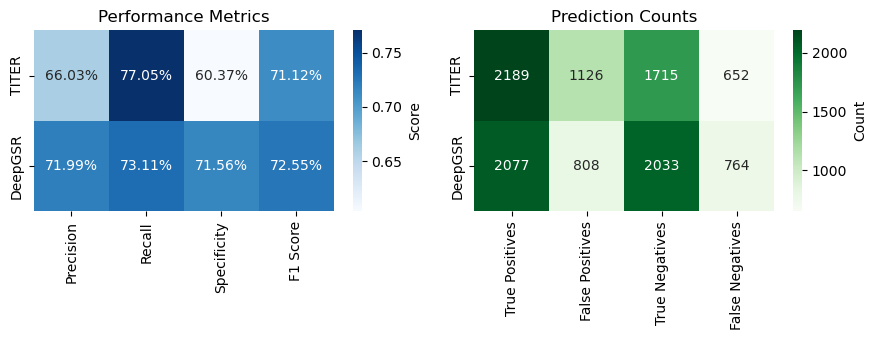

In [80]:
benchmark_deepML = pd.read_csv('output/deepML/benchmark_titer_deepgsr_(raw).csv')

import seaborn as sns
def calculate_metrics(df):
    metrics = {}
    for method in df['method'].unique():
        method_data = df[df['method'] == method]
        
        # Basic metrics
        total = len(method_data)
        true_positives = len(method_data[(method_data['true_label'] == 1) & (method_data['prediction_label'] == 1)])
        false_positives = len(method_data[(method_data['true_label'] == 0) & (method_data['prediction_label'] == 1)])
        false_negatives = len(method_data[(method_data['true_label'] == 1) & (method_data['prediction_label'] == 0)])
        true_negatives = len(method_data[(method_data['true_label'] == 0) & (method_data['prediction_label'] == 0)])
        
        # Calculate derived metrics
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[method] = {
            'Total Predictions': total,
            'True Positives': true_positives,
            'True Negatives': true_negatives,
            'False Positives': false_positives,
            'False Negatives': false_negatives,
            'Precision': precision,
            'Recall': recall,
            'Specificity': specificity,
            'F1 Score': f1_score
        }
    
    return pd.DataFrame(metrics).T

# Calculate metrics
metrics_df = calculate_metrics(benchmark_deepML)

# Display the dataframe with formatted values
display_df = metrics_df.copy()
display_df['Precision'] = display_df['Precision'].map('{:.2%}'.format)
display_df['Recall'] = display_df['Recall'].map('{:.2%}'.format)
display_df['Specificity'] = display_df['Specificity'].map('{:.2%}'.format)
display_df['F1 Score'] = display_df['F1 Score'].map('{:.2%}'.format)
display_df.drop(columns=['Total Predictions'], inplace=True)
display_df['Training Duration (h)'] = ['84.4', '106.7']
print("\nPerformance Metrics per Method:")
# display(display_df)

styled_df = display_df.style.set_table_styles([
    {'selector': 'th', 'props': [('padding', '4px'), ('font-size', '10pt')]},
    {'selector': 'td', 'props': [('padding', '4px'), ('font-size', '10pt')]},
    {'selector': 'table', 'props': [('width', '100%'), ('table-layout', 'fixed')]}
])

styled_df.set_properties(**{'max-width': '50px'}).set_table_attributes('style="display:inline"')
display(styled_df)

display_df.to_csv('output/deepML/benchmark_deepML_(metrics).csv', index=False)

# Create figure with 3 subplots
plt.figure(figsize=(9, 3.5))
plt.subplot(1, 2, 1)
sns.heatmap(metrics_df[['Precision', 'Recall', 'Specificity', 'F1 Score']], 
            annot=True, 
            fmt='.2%', 
            cmap='Blues',
            cbar_kws={'label': 'Score'})
plt.title('Performance Metrics')
plt.subplot(1, 2, 2)
sns.heatmap(metrics_df[['True Positives', 'False Positives', 'True Negatives', 'False Negatives']], 
            annot=True, 
            fmt='.0f',
            cmap='Greens',
            cbar_kws={'label': 'Count'})
plt.title('Prediction Counts')
plt.savefig('output/deepML/benchmark_deepML_(metrics).png', dpi=300)
plt.tight_layout()
plt.show()

In [ ]:
# END